<a href="https://colab.research.google.com/github/eentartetekunst/NGS_bioinformatics/blob/main/HW3_edgeR_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R Kernel in colab

In [11]:
install.packages("googledrive")
library("googledrive")

if (file.exists("/usr/local/lib/python3.6/dist-packages/google/colab/_ipython.py")){ 
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
} 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#  install libs

In [12]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.15")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Old packages: 'bslib', 'callr', 'data.table', 'devtools', 'digest', 'ggplot2',
  'jsonlite', 'lubridate', 'openssl', 'pkgload', 'processx', 'ps', 'roxygen2',
  'sys', 'tibble', 'tidyverse', 'vctrs', 'xfun', 'yaml', 'zip', 'foreign',
  'mgcv', 'rpart'



In [13]:
BiocManager::install(c("edgeR"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Old packages: 'bslib', 'callr', 'data.table', 'devtools', 'digest', 'ggplot2',
  'jsonlite', 'lubridate', 'openssl', 'pkgload', 'processx', 'ps', 'roxygen2',
  'sys', 'tibble', 'tidyverse', 'vctrs', 'xfun', 'yaml', 'zip', 'foreign',
  'mgcv', 'rpart'



In [14]:
library(edgeR)

Loading required package: limma



In [15]:
install.packages("statmod")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [16]:
install.packages('plotly')
library(plotly) 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [17]:
install.packages('dendextend')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘viridis’




In [18]:
library(dendextend)


---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




# load data

In [19]:
GenewiseCounts <- read.csv("/content/GenewiseCounts.csv", row.names = 1)  # row.names = 1 переиндексирует дф по 1 столбцу (названия генов)

# read data

In [20]:
head(GenewiseCounts) # d 

,Length,B14_5,B15_5,B17_5,B20,B34,C14_5,C15_5,C17_5,C20,C34
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000077223,128,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000044387,414,0,0,0,0,3,0,0,0,0,0
ENSMUSG00000033863,4815,46,60,188,449,4375,54,88,85,189,2934
ENSMUSG00000080626,121,0,0,0,0,3,0,0,0,0,1
ENSMUSG00000006456,3910,740,826,651,474,298,468,673,507,520,310
ENSMUSG00000095913,663,15,10,8,12,5,16,7,9,5,8


In [21]:
Age <- c(14.5, 15.5, 17.5, 20, 34, 14.5, 15.5, 17.5, 20, 34)
Tissue <- c("B","B","B","B","B", "C", "C", "C", "C", "C")

targets <- data.frame(Age, Tissue)
targets # m

Age,Tissue
<dbl>,<chr>
14.5,B
15.5,B
17.5,B
20.0,B
34.0,B
14.5,C
15.5,C
17.5,C
20.0,C


In [22]:
d = GenewiseCounts[,-1] # we do not need gene length
d = as.matrix(d)
m = data.frame(tissue=substr(colnames(d),1,1),age=as.numeric(sub('_','.',substr(colnames(d),2,10))))
m$col=ifelse(m$tissue=='B','purple','pink')
rownames(m) = colnames(d)
m

,tissue,age,col
,<chr>,<dbl>,<chr>
B14_5,B,14.5,purple
B15_5,B,15.5,purple
B17_5,B,17.5,purple
B20,B,20.0,purple
B34,B,34.0,purple
C14_5,C,14.5,pink
C15_5,C,15.5,pink
C17_5,C,17.5,pink
C20,C,20.0,pink


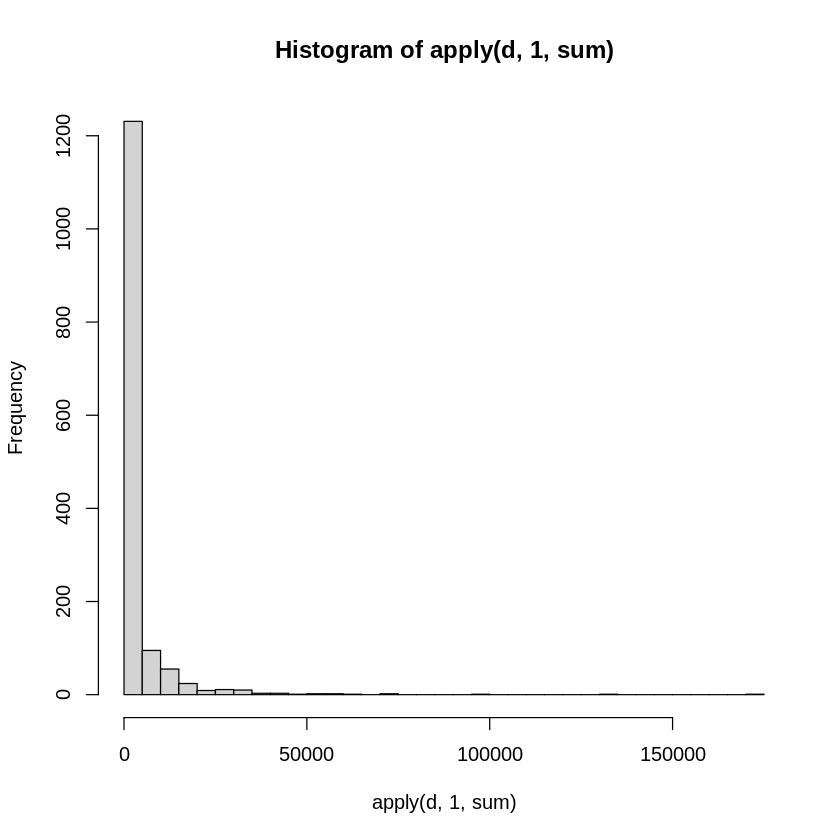

In [23]:
hist(apply(d,1,sum),40)

# remove genes with low level count (less then 9 counts)

In [24]:
table(apply(d,1,sum)>9)
d = d[apply(d,1,sum)>9,]


FALSE  TRUE 
  639   813 

# Normalize lib size

In [25]:
#y <- DGEList(GenewiseCounts[-c(1:2)], genes=GenewiseCounts[,1,drop=FALSE], group=Group)
#y = calcNormFactors(y,method='RLE') 
#options(digits=3)
#y$samples

# remove duplicates if any

In [26]:
#length(unique(GenewiseCounts$X))
#length(unique(GenewiseCounts$X)) == nrow(GenewiseCounts)

all genes are unique, in other cases use:

In [27]:
#o <- order(rowSums(y$counts), decreasing=TRUE)
#y <- y[o,]
#d <- duplicated(y$genes$Symbol)
#y <- y[!d,]
#nrow(y)

In [ ]:
# plotBCV(y)

In [29]:
edger = DGEList(d) 
edger = calcNormFactors(edger,method='RLE') 
edger$samples 

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
B14_5,1,434119,1.0166660
B15_5,1,416563,1.0458669
B17_5,1,414804,1.0474981
B20,1,432298,1.0188563
B34,1,451411,0.8826193
C14_5,1,427690,1.0138074
C15_5,1,413139,1.0479183
C17_5,1,445304,0.9796607
C20,1,446050,1.0565547


#2. Используя данные из предыдущего ДЗ при помощи edgeR найти гены с межтканевыми и/или возрастными изменениями экспресии 
1. (корректированное p-value < 0.05, межтканевые отличия должны быть не менее чем в два раза)
2. возрастные изменения можно считать линейными по возрасту. 
3. Используйте модель ~ tissue + age

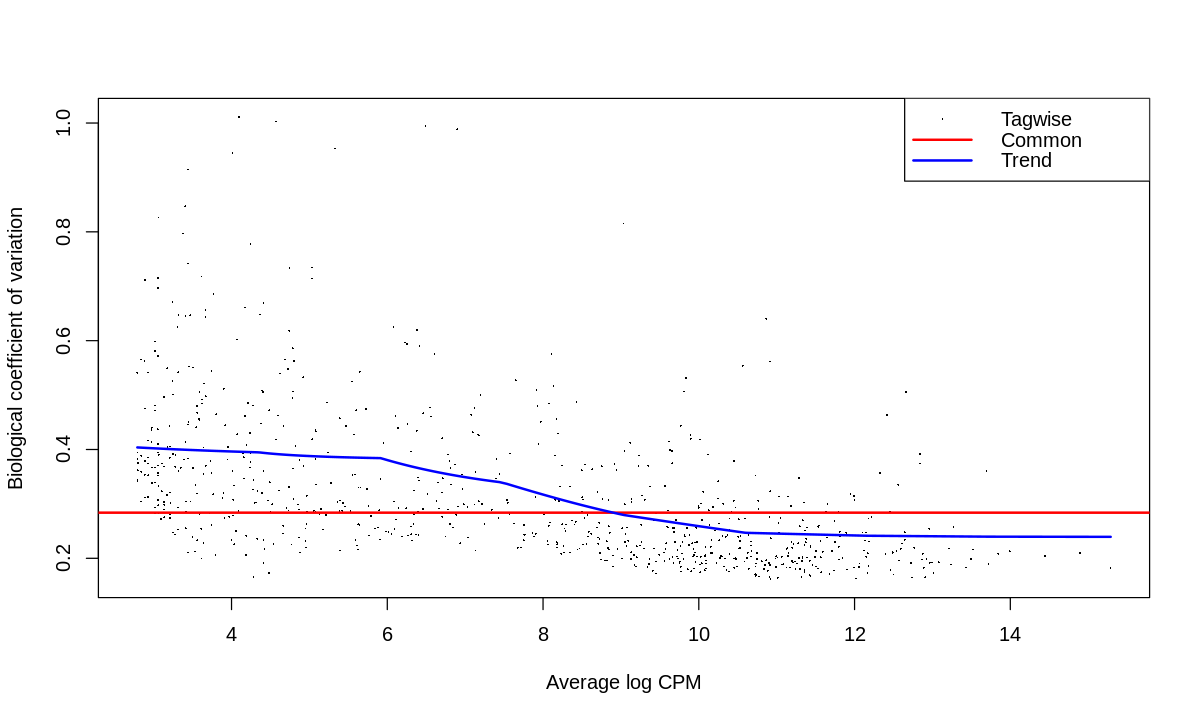

In [30]:
options(repr.plot.width=10, repr.plot.height=6)
design = model.matrix(~ tissue + age, data = m) 
edger = estimateDisp(edger,design)  # estimate dispersion
plotBCV(edger)

In [32]:
edger$common.dispersion

[1] 0.08061203

The square root of the common dispersion gives the coefficient of variation of biological variation. Here the common dispersion is found to be 0.08, so the coefficient of biological variation is around 0.3.

## examine the samples for outliers

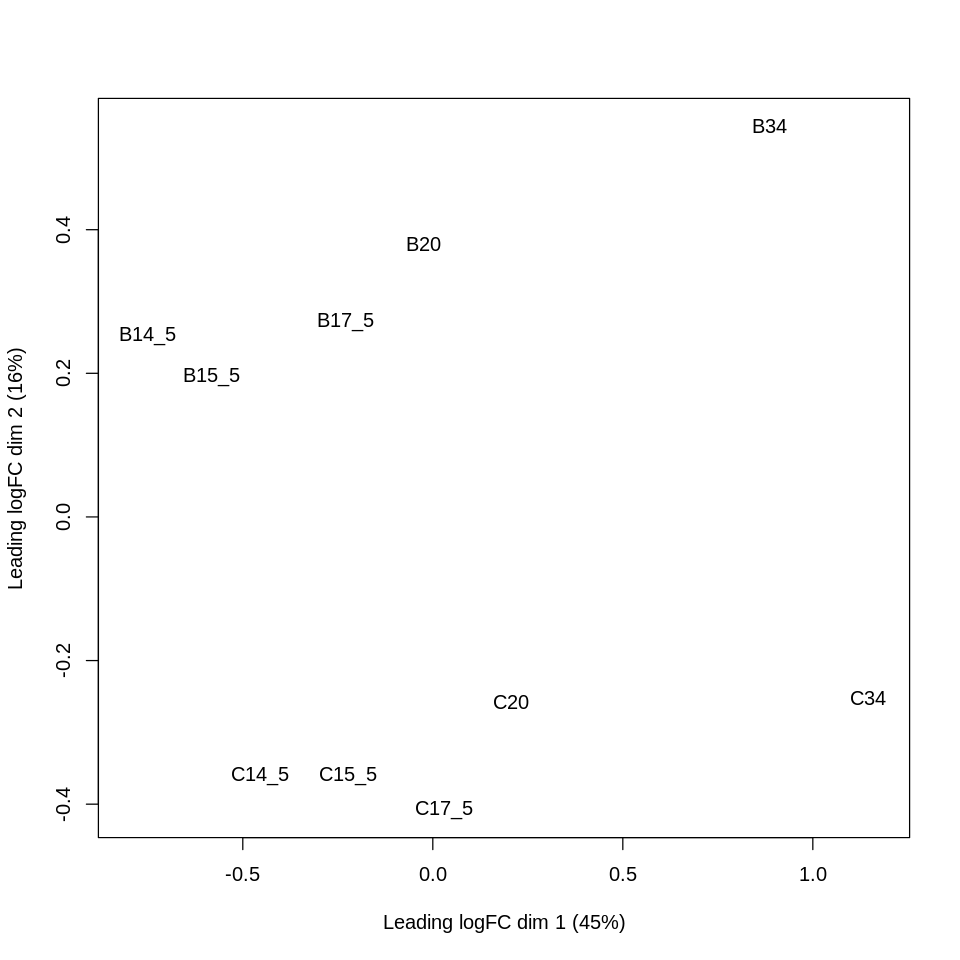

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)

plotMDS(edger)

dim 1  separates the samples by age; dim 2 separates the samples by tissues


In [ ]:
design

,(Intercept),tissueC,age
B14_5,1,0,14.5
B15_5,1,0,15.5
B17_5,1,0,17.5
B20,1,0,20.0
B34,1,0,34.0
C14_5,1,1,14.5
C15_5,1,1,15.5
C17_5,1,1,17.5
C20,1,1,20.0
C34,1,1,34.0


In [34]:
glm = glmFit(edger,design) # обучает линейную регрессию по нашим данным, модель - ткань+возраст

In [35]:
design

,(Intercept),tissueC,age
B14_5,1,0,14.5
B15_5,1,0,15.5
B17_5,1,0,17.5
B20,1,0,20.0
B34,1,0,34.0
C14_5,1,1,14.5
C15_5,1,1,15.5
C17_5,1,1,17.5
C20,1,1,20.0
C34,1,1,34.0


In [37]:
# head(glmLRT(glm)$table)
# таблица с logFC logCPM  LR PValue для генов

In [38]:
head(glmLRT(glm,3)$table)

,logFC,logCPM,LR,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000033863,0.3080028687,11.032257,2.680110e+02,3.079042e-60
ENSMUSG00000006456,-0.0513510419,10.300973,1.333318e+01,2.607505e-04
ENSMUSG00000095913,-0.0385947463,4.732260,1.722754e+00,1.893389e-01
ENSMUSG00000025075,-0.1721156698,3.406715,3.155286e+00,7.568142e-02
ENSMUSG00000034108,-0.0006637451,8.745408,2.424853e-03,9.607258e-01
ENSMUSG00000067872,0.0490449364,5.547369,1.509996e+00,2.191397e-01


In [39]:
head(glmLRT(glm,2)$table)

,logFC,logCPM,LR,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000033863,-0.5826881,11.032257,3.8207017,0.05062303
ENSMUSG00000006456,-0.2421880,10.300973,1.6156819,0.20369494
ENSMUSG00000095913,-0.1409610,4.732260,0.1285816,0.71990720
ENSMUSG00000025075,-0.5213633,3.406715,0.2728921,0.60139830
ENSMUSG00000034108,0.2123643,8.745408,1.2143123,0.27047976
ENSMUSG00000067872,-0.2894739,5.547369,0.2746914,0.60020197


In [40]:
glmLRT(glm)

An object of class "DGELRT"
$coefficients
                   (Intercept)     tissueC           age
ENSMUSG00000033863  -11.675604 -0.40388859  0.2134913201
ENSMUSG00000006456   -5.906417 -0.16787190 -0.0355938299
ENSMUSG00000095913  -10.143262 -0.09770671 -0.0267518396
ENSMUSG00000025075   -9.611364 -0.36138151 -0.1193014913
ENSMUSG00000034108   -7.830874  0.14719972 -0.0004600731
808 more rows ...

$fitted.values
                        B14_5      B15_5      B17_5        B20          B34
ENSMUSG00000033863  82.785986 101.177478 154.680980 267.441888 4811.4600489
ENSMUSG00000006456 716.875473 682.890831 634.257210 588.178653  323.2095406
ENSMUSG00000095913  11.655314  11.196977  10.576778  10.017754    6.1960479
ENSMUSG00000025075   5.308407   4.565857   3.457303   2.483748    0.3267307
ENSMUSG00000034108 174.047230 171.726406 171.110251 173.251058  155.7128739
                        C14_5      C15_5     C17_5        C20          C34
ENSMUSG00000033863  54.287857  67.111781 103.66244 

In [41]:
pv = cbind(tissue = glmLRT(glm,2)$table$PValue, 
           age = glmLRT(glm,3)$table$PValue)

In [42]:
rownames(pv) = rownames(d)

In [43]:
head(pv)

,tissue,age
ENSMUSG00000033863,0.05062303,3.079042e-60
ENSMUSG00000006456,0.20369494,2.607505e-04
ENSMUSG00000095913,0.71990720,1.893389e-01
ENSMUSG00000025075,0.60139830,7.568142e-02
ENSMUSG00000034108,0.27047976,9.607258e-01
ENSMUSG00000067872,0.60020197,2.191397e-01


In [44]:
qv = apply(pv,2,p.adjust,m='BH') # сделаем поправку на множественное тестирование
# BH - Benjamini method

In [45]:
apply(qv < 0.05, 2, sum) # количество генов значимых для каждого фактора

tissue    age 
    46    284

In [46]:
cpm = cpm(edger)

In [ ]:
qv[order(qv[,2])[1:10],] # top 10 differentially expressed genes depending on age

,tissue,age
ENSMUSG00000050121,0.05074,3.86e-69
ENSMUSG00000033863,0.29597,1.25e-57
ENSMUSG00000036098,0.07179,3.66e-56
ENSMUSG00000025190,0.05883,3.47e-41
ENSMUSG00000039126,0.00376,1.36e-37
ENSMUSG00000025189,0.52138,9.38e-26
ENSMUSG00000037071,0.55898,2.12e-24
ENSMUSG00000032648,0.05883,4.70e-24
ENSMUSG00000049303,0.04983,9.05e-23
ENSMUSG00000046324,0.32229,2.58e-22


In [ ]:
qv[order(qv[,1])[1:10],] # top 10 tissue-specific genes

,tissue,age
ENSMUSG00000097683,1.02e-16,4.09e-03
ENSMUSG00000032773,1.54e-10,1.17e-04
ENSMUSG00000025229,8.35e-10,4.81e-02
ENSMUSG00000042372,4.37e-09,4.95e-06
ENSMUSG00000053279,4.37e-09,1.47e-12
ENSMUSG00000048138,8.38e-08,8.33e-01
ENSMUSG00000120254,1.21e-07,9.36e-01
ENSMUSG00000044220,4.38e-06,2.65e-13
ENSMUSG00000058624,4.68e-06,3.39e-06
ENSMUSG00000003559,6.81e-06,8.97e-01


In [ ]:
head(m)

,tissue,age,col
,<chr>,<dbl>,<chr>
B14_5,B,14.5,purple
B15_5,B,15.5,purple
B17_5,B,17.5,purple
B20,B,20.0,purple
B34,B,34.0,purple
C14_5,C,14.5,pink


# Отшкалируйте экспрессию каждого гена к среднему ноль и дисперсии один (z-score)

In [48]:
cpm.s = cpm[apply(qv,1,min)<0.05,] # take significant genes (by tissue = 1; by age = 2)
cpm.s = t(scale(t(cpm.s))) # z-score scaling (z-score_i = (x_i - mean)/std)
head(cpm.s)

,B14_5,B15_5,B17_5,B20,B34,C14_5,C15_5,C17_5,C20,C34
ENSMUSG00000033863,-0.5191590,-0.51040935,-0.4333590,-0.28008720,2.3220852,-0.5138521,-0.4932874,-0.495486831,-0.44162318,1.3651788
ENSMUSG00000006456,1.0959661,1.66828145,0.6303168,-0.47132691,-1.3280121,-0.4630419,0.7771337,-0.246829539,-0.40029791,-1.2621898
ENSMUSG00000083282,-0.9509952,-0.68281050,-0.4802414,-0.41272606,0.6244335,-0.3774475,-0.2815834,0.007940922,-0.01879001,2.5722197
ENSMUSG00000044424,1.1865552,0.71456015,0.5757271,0.20372996,-1.5333268,0.3544124,0.2173822,0.774924306,-0.76008809,-1.7338763
ENSMUSG00000051255,1.8050320,-0.04818429,0.3310064,0.06659035,-1.2324129,1.4168642,-0.4576944,0.003689313,-0.70444474,-1.1804459
ENSMUSG00000024897,-1.4324687,-1.06703396,-0.3244702,0.25690494,1.6976710,-0.7708402,-0.2936262,0.917523292,1.10707343,-0.0907333


# Скалстеризуйте гены значимые хотя бы по одному фактору при помощи иерархической кластеризации (расстояние 1 — коэффициент корреляции Спирмана) в 6 кластеров.

In [49]:
hcl = hclust(as.dist(1-cor(t(cpm.s)))) # иерархическая кластеризация

In [50]:
cl = cutree(hcl,6) #  отсекает 6 кластеров
table(cl) # число генов в каждом кластере

cl
 1  2  3  4  5  6 
63 54 83 62 14 23 

In [52]:
options(repr.plot.width=20, repr.plot.height=8)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: ignored

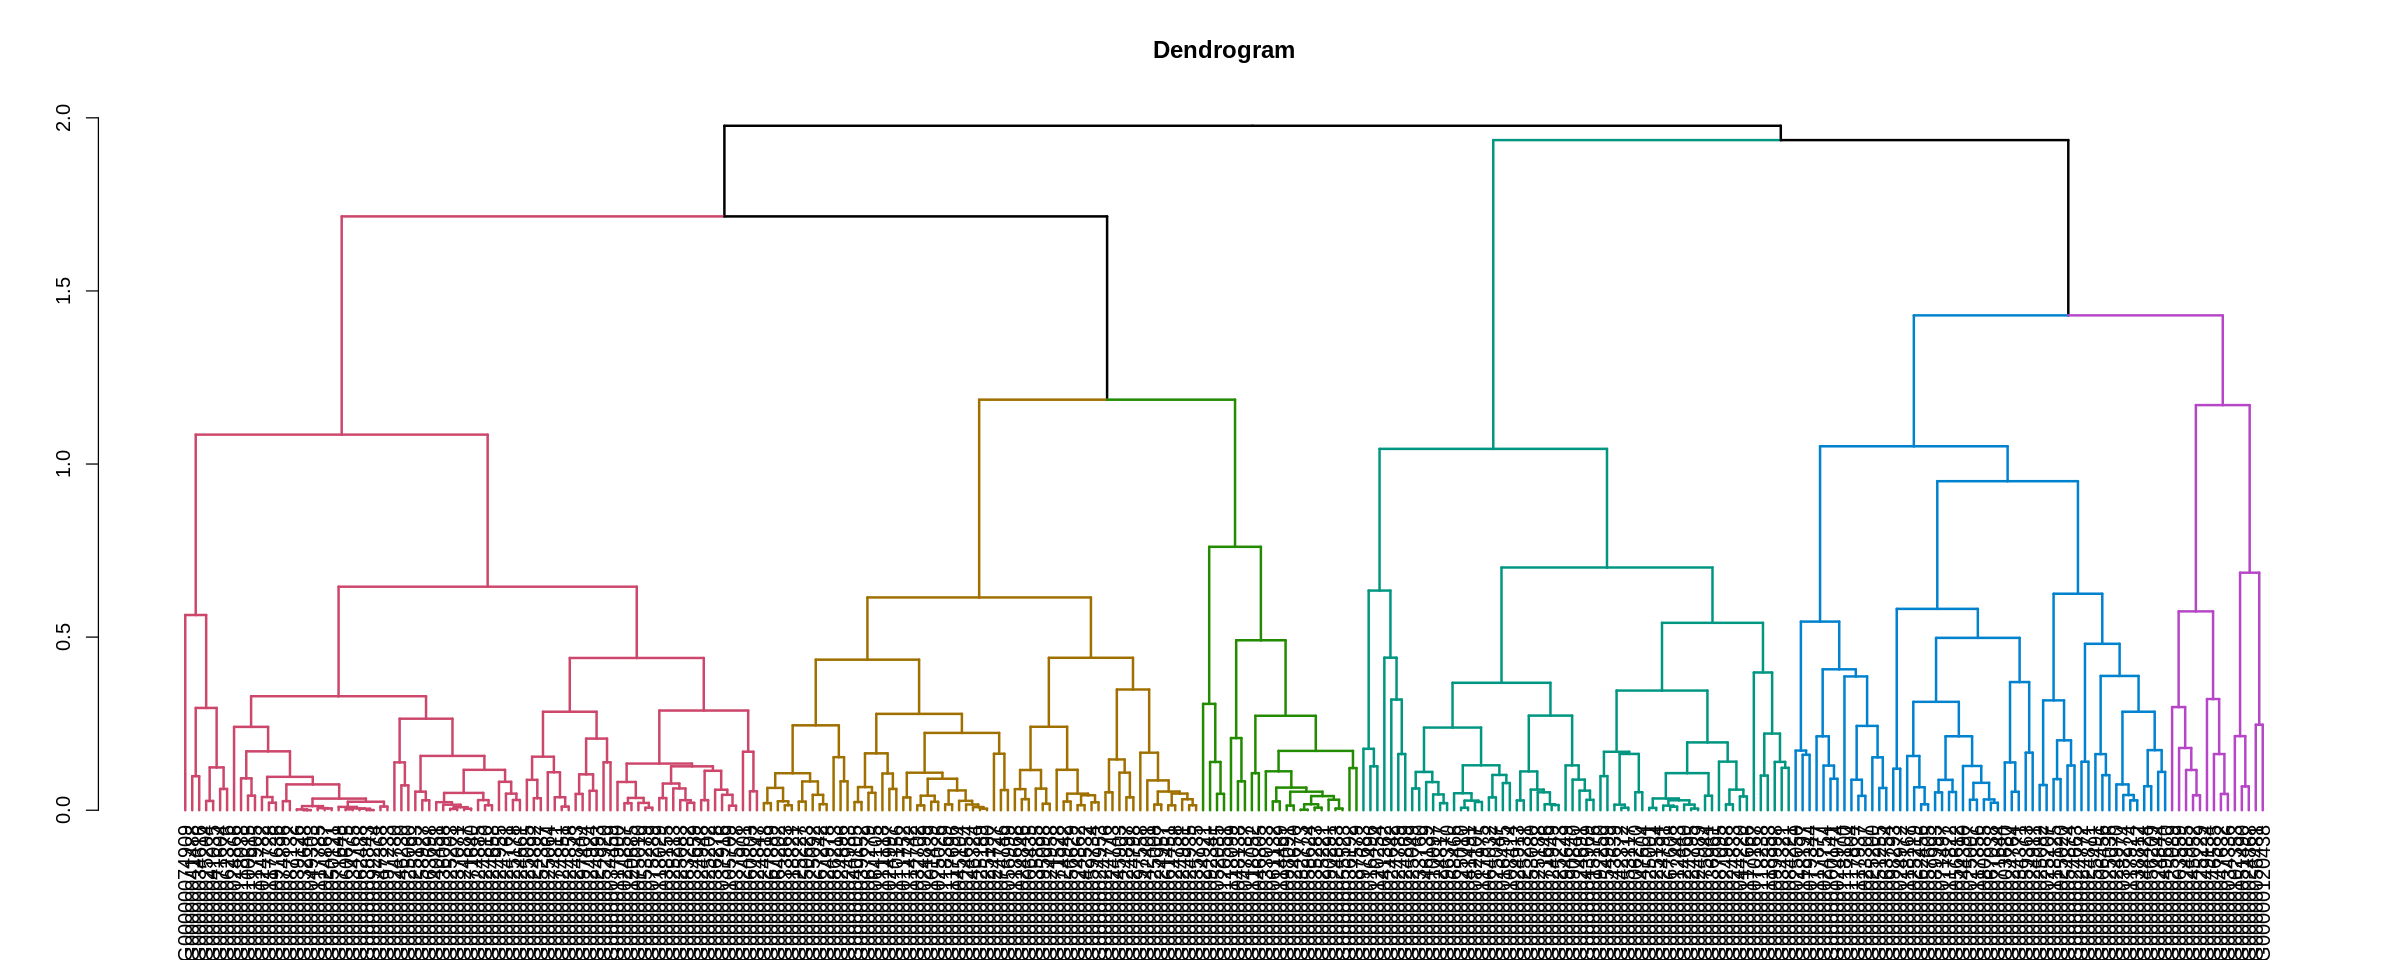

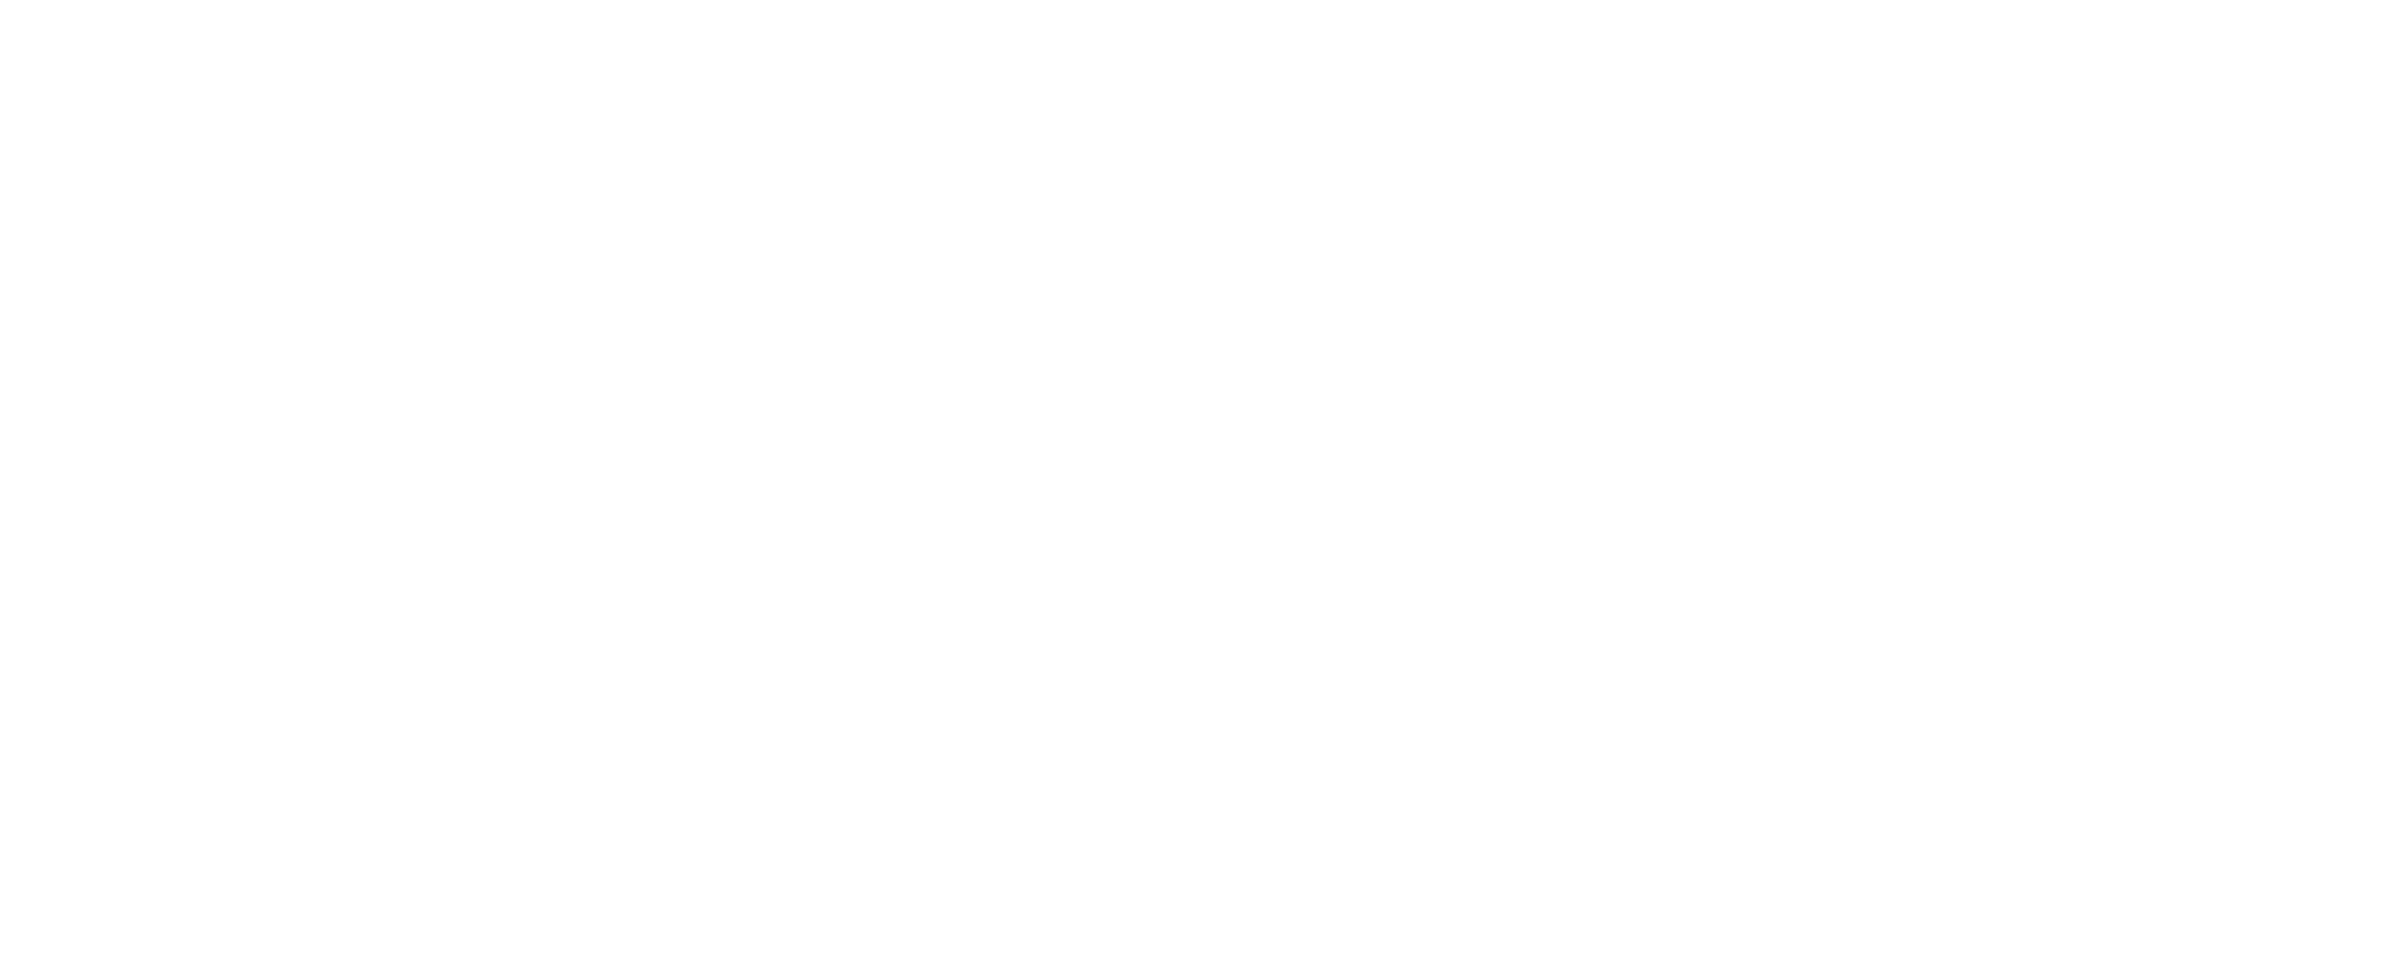

In [53]:
dend <- as.dendrogram(hcl)
dend <- dend %>% color_branches(k = 6) %>% set("branches_lwd", 2) %>% plot(main = "Dendrogram")

plot(dend)

# Нарисуйте для каждого кластера зависимость среднего z-score от возраста для обоих тканей

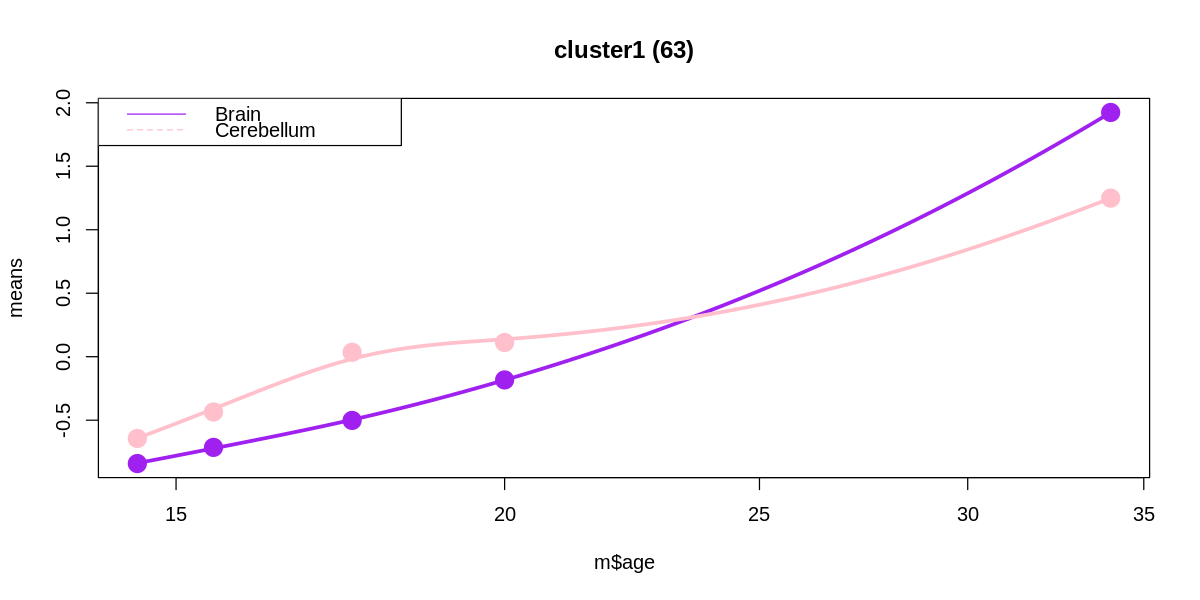

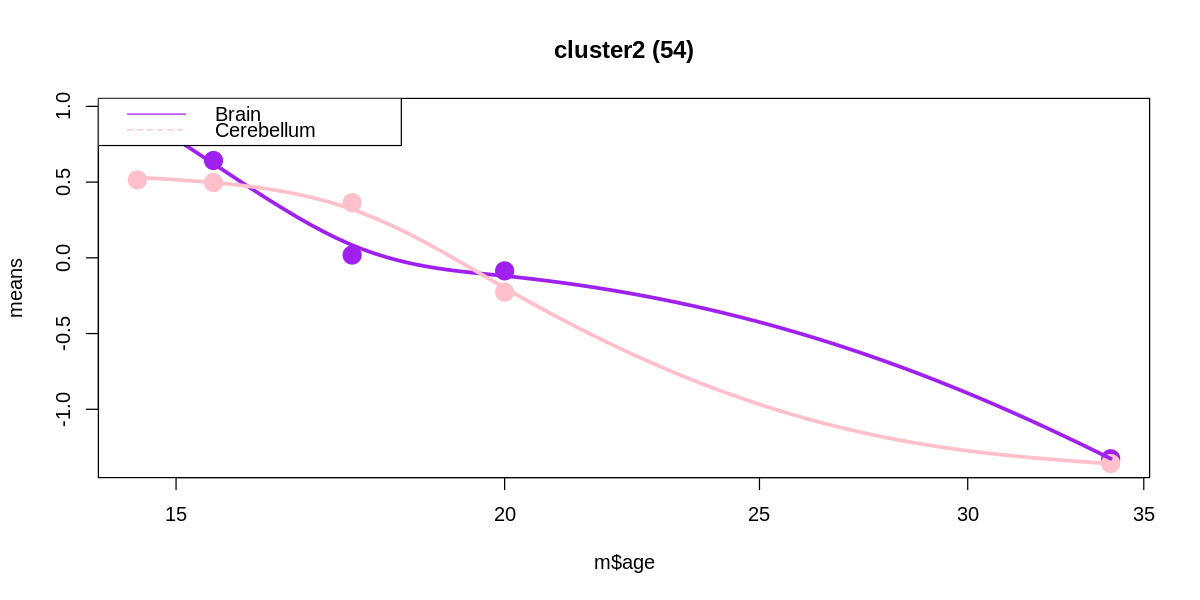

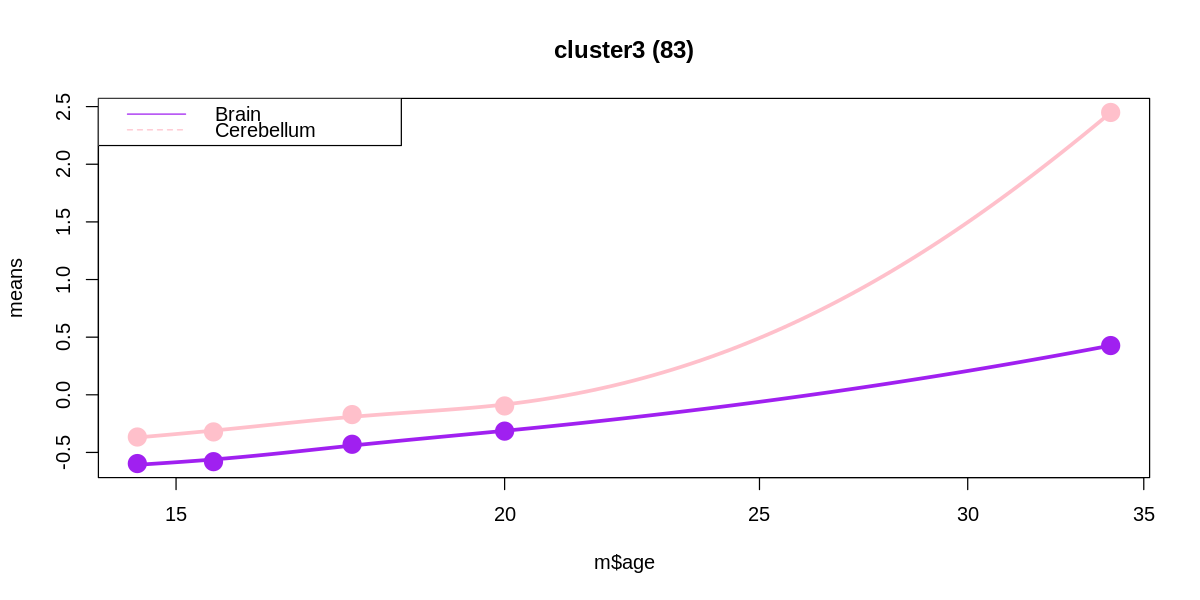

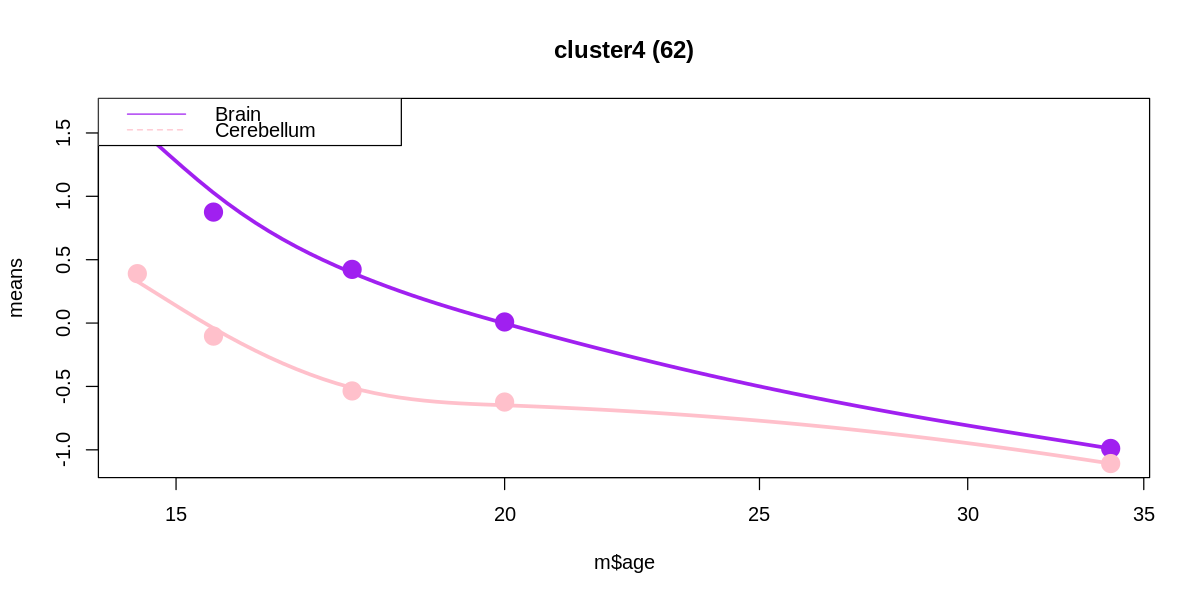

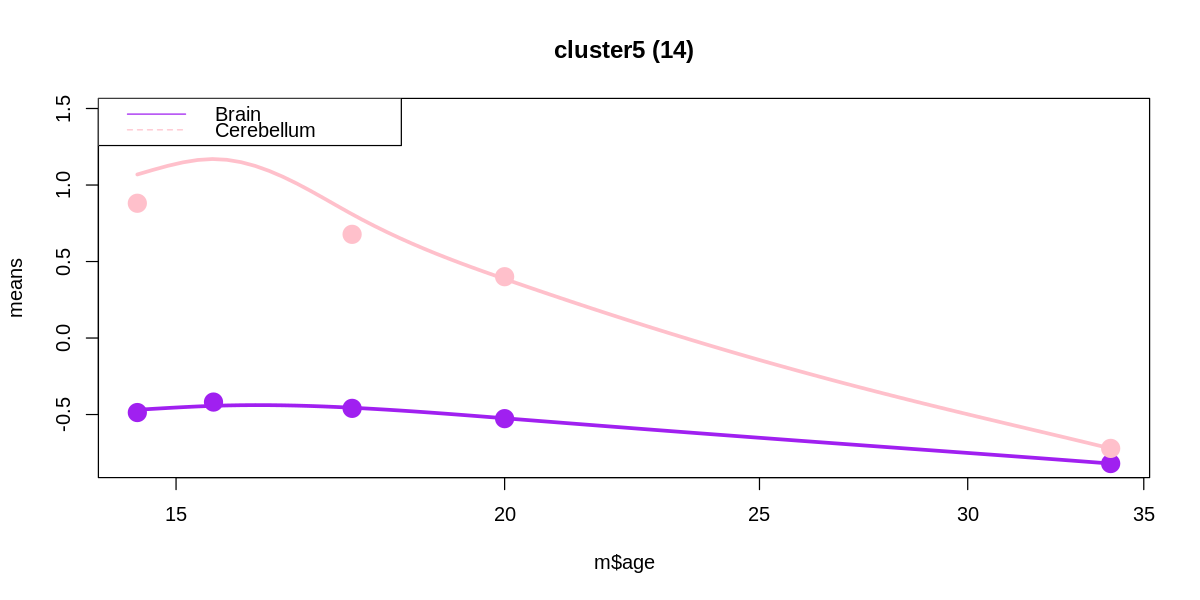

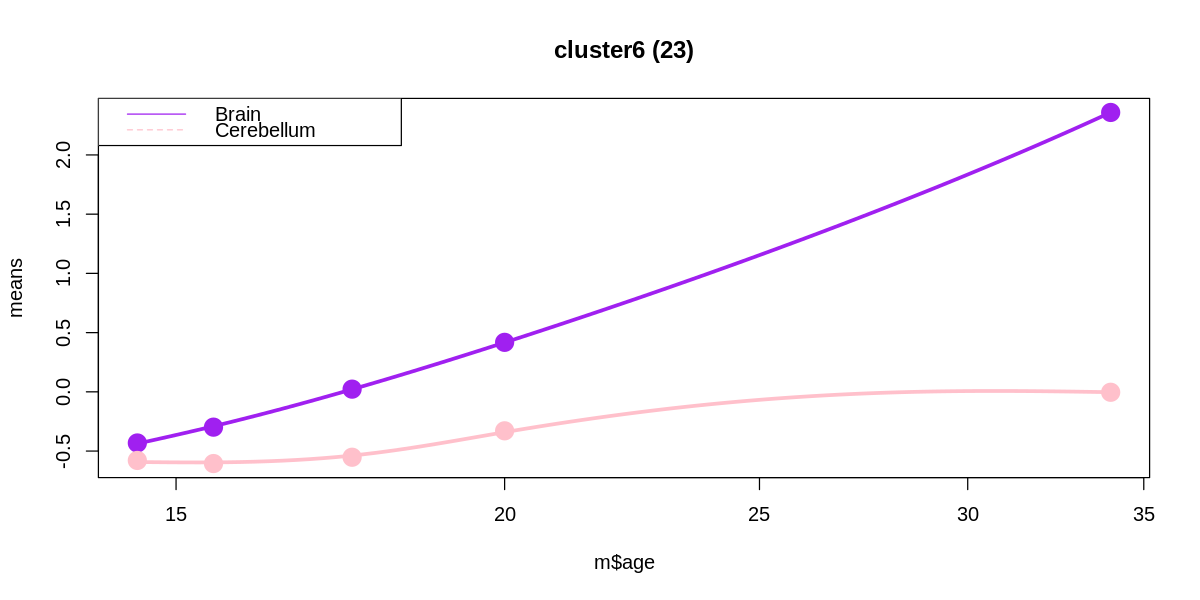

In [58]:
options(repr.plot.width=10, repr.plot.height=5)
for(clustno in unique(cl)){  
  means = apply(cpm.s[cl==clustno,,drop=F],2,mean)  # средние экспресси для данного кластера
  plot(m$age,means,pch=19,col=m$col,main=paste0(sprintf("cluster%s", clustno),' (',sum(cl==clustno),')'),log='x',cex=2) # рисуем средние занчения

  for(t in unique(m$tissue)){  # перебираем ткани 
    f = m$tissue == t # отбираем образцы относящиеся к данной ткани
    ss = smooth.spline(m$age[f],means[f],df=4) # апроксимируем зависимость сплайном
    ss = predict(ss,seq(min(m$age),max(m$age),length.out=100)) # интерполируем
    lines(ss,lwd=3,col=m$col[f][1]) # рисуем апроксимацию
  }
  legend("topleft", legend=c("Brain", "Cerebellum"),
       col=c("purple", "pink"), lty=1:2, cex=1)
}




в день 14.5 экспрессия первого кластера генов была примерно на 1 стандартное отклонение ниже средней экспрессии для обеих тканей (для мозга чуть ниже). С возрастом z-score кластеров рос, соответственно, средняя экспрессия генов из этого кластера становилась выше средней -> экспрессия генов из 1 кластера положительно коррелирована с возрастом. Похожая тенденция наблюдается в кластерах 1, 3, 6. Эти гены могут иметь специализированную функцию. Например, в кластере 3 в последние дни наблюдейний происходит резкий скачок в их экспрессии в мозгу, но не в мозжечке. 

В кластерах 2, 4, 5, напротив, с течением времени понижается уровень экспрессии по сравнению со средним. Можно предположить, что эти гены как-то ассоциированы с ранним развитием эмбриона и они теряют свою значимость на более поздних стадиях дифференцировки.  Кластер 5 на ранних этапах имел высокие значения для мозжечка, но не мозга. Вероятно, эта группа генов отвечает за развитие мозжечка. 




